In [1]:
# Re-implementation of https://github.com/google/brain-tokyo-workshop/tree/master/AttentionNeuron
# Paper: https://attentionneuron.github.io/
# Google AI Blog post: https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html
import functools
import time
import math

import cma
import gym
import gnwrapper
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from torch import nn
import torch

In [2]:
class FCNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=4, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

    def reset(self):
        pass


def pos_table(n, dim):
    """
    Copy pasted from: https://github.com/google/brain-tokyo-workshop/blob/301a6ea6cadc61a63b06c881a07f54f6cd1f2273/AttentionNeuron/solutions/torch_modules.py#L6
    """
    def get_angle(x, h):
        return x / np.power(10000, 2 * (h // 2) / dim)

    def get_angle_vec(x):
        return [get_angle(x, j) for j in range(dim)]

    tab = np.array([get_angle_vec(i) for i in range(n)]).astype(float)
    tab[:, 0::2] = np.sin(tab[:, 0::2])
    tab[:, 1::2] = np.cos(tab[:, 1::2])
    return tab


class AttentionNeuron(nn.Module):
    def __init__(self):
        super().__init__()
        query_size = 8
        obs_size = 4  # Acts as batch size for some parts
        message_size = 32
        
        self.previous_action = 0
        
        self.lstm = nn.LSTMCell(input_size=2, hidden_size=query_size)
        self.hx = (torch.zeros(obs_size, query_size), torch.zeros(obs_size, query_size))

        self.q = torch.from_numpy(pos_table(16, query_size)).float()
        self.fq = nn.Linear(in_features=query_size, out_features=message_size, bias=False)
        self.fk = nn.Linear(in_features=query_size, out_features=message_size, bias=False)
        
        self.head = nn.Sequential(
            nn.Linear(in_features=16, out_features=1)
        )
        
    def forward(self, o):
        # Reshape from 1 sample, 4 features to 4 samples 1 feature
        o = o.unsqueeze(-1)
        
        # Add previous action to the observation as the input for the LSTM
        x_pa = torch.cat([o, torch.full((o.shape[0], 1), self.previous_action)], dim=-1)
        self.hx = self.lstm(x_pa, self.hx)
        
        # Compute attention matrix
        q = self.fq(self.q)
        k = self.fk(self.hx[0])
        dot = torch.matmul(q, k.T)
        attention_matrix = torch.div(dot, math.sqrt(1))

        w = torch.tanh(attention_matrix)
        # Weight observation based on attention weights
        x = torch.tanh(torch.matmul(w, o))
        
        # Go back to single batch
        action = self.head(x.T).sigmoid()
        self.previous_action = 0 if action < 0.5 else 1
        return self.previous_action
    
    def reset(self):
        query_size = 8
        obs_size = 4  # Acts as batch size for some parts        
        self.hx = (torch.zeros(obs_size, query_size), torch.zeros(obs_size, query_size))
        self.previous_action = 0

In [3]:
def torch_obs(obs):
    return torch.from_numpy(obs).to(torch.float32)


def gym_action(action):
    return 0 if action < 0.5 else 1


def num_parameters(model):
    return sum(p.numel() for p in model.parameters())


def set_params(model, params):
    params = torch.from_numpy(params).to(torch.float32)
    i = 0
    for name, param in model.named_parameters():
        param_shape = param.data.shape        
        param_size = param.numel()
        
        new_param_data = params[i: i + param_size]
        if len(param_shape) > 1:
            new_param_data = new_param_data.reshape(param_shape)

        param.data = new_param_data
        i += param_size

In [4]:
def fitness(model, env, trials=3):
    fitnesses = []
    for _ in range(trials):
        fitnesses.append(one_run(model, env))
    return sum(fitnesses) / trials


def one_run(model, env, perm=None):
    model.reset()
    obs = env.reset()
    if perm is None:
        perm = np.arange(obs.shape[0])
    obs = obs[perm]
    total_reward = 0
    for _ in range(1000):
        with torch.no_grad():
            action = gym_action(model(torch_obs(obs)))

        next_obs, reward, done, info = env.step(action)
        next_obs = next_obs[perm]
        
        total_reward += 1
        
        if isinstance(env, gnwrapper.Animation):
            env.render()

        obs = next_obs
        if done:
            env.reset()
            break
    return total_reward

In [5]:
def plot_evolution(fitness_history):
    # Plot population progress
    fh = np.array(fitness_history)
    plt.plot(np.quantile(fh, 0.5, axis=1), label="median")
    plt.plot(np.max(fh, axis=1), label="best")
    for low, high, alpha in [(0.05, 0.95, 0.1), (0.25, 0.75, 0.3)]:
        low = np.quantile(fh, low, axis=1)
        high = np.quantile(fh, high, axis=1)
        plt.fill_between(np.arange(len(fh)), low, high, color="grey", alpha=alpha)
    
    plt.ylabel("reward")
    plt.xlabel("generation")
    plt.legend()
    plt.show()


def fit_model(model, env, max_iter=1000):
    solver = cma.CMAEvolutionStrategy(
        x0=np.zeros(num_parameters(model)),
        sigma0=1.0,  # 0.1 in the original code
        inopts={
            'popsize': 10,  # 256 in the original code
            'randn': np.random.randn,
        },
    )
    
    fitness_history = []
    best_fitness = -1
    best_params = None
    for i in range(max_iter):
        # Get suggested params
        pop_params = solver.ask()

        # Evaluate params
        pop_fitness = []
        for params in pop_params:
            set_params(model, params)
            pop_fitness.append(fitness(model, env))
        fitness_history.append(pop_fitness)

        # Update the solver with the fitness for the evaluated
        # params
        solver.tell(pop_params, [-i for i in pop_fitness])

        # Update the best params
        max_pop_fitness = max(pop_fitness)
        if max_pop_fitness > best_fitness:
            best_fitness = max_pop_fitness
            best_params = pop_params[pop_fitness.index(max_pop_fitness)]

    return best_params, np.array(fitness_history)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 369 (seed=571342, Sun Nov 21 01:22:40 2021)


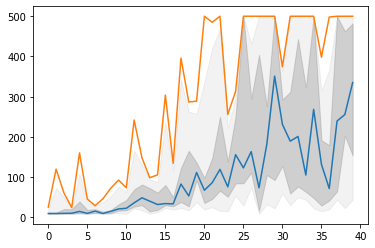

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 913 (seed=559786, Sun Nov 21 01:22:52 2021)


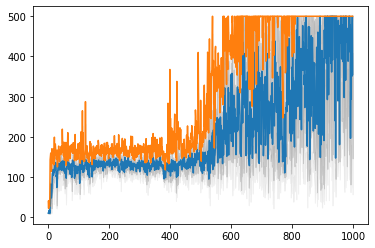

In [6]:
env = gym.make('CartPole-v1')

fc_nn = FCNNet().eval()
fc_nn_params, fc_nn_history = fit_model(
    fc_nn,
    env,
    max_iter=100
)
set_params(fc_nn, fc_nn_params)
plot_evolution(fc_nn_history)

attention_neuron = AttentionNeuron().eval()
attention_neuron_params, attention_neuron_history = fit_model(
    attention_neuron,
    env,
    # Lots more steps required to converge
    max_iter=1000
)
set_params(attention_neuron, attention_neuron_params)
plot_evolution(attention_neuron_history)

In [38]:
# Check that the model is more invariant to permutations that a fully connected neural network
results = []
for model, model_label in [(fc_nn, "FCNN"), (attention_neuron, "AttentionNeuron")]:
    for perm, perm_label in [
        (np.array([0, 1, 2, 3]), False),
        (np.array([2, 0, 3, 1]), True)
    ]:
        fitnesses = []
        for _ in range(100):
            fitnesses.append(one_run(model, env, perm))

        for fitness in fitnesses:
            results.append({"model": model_label, "permuted": perm_label, "fitness": fitness})

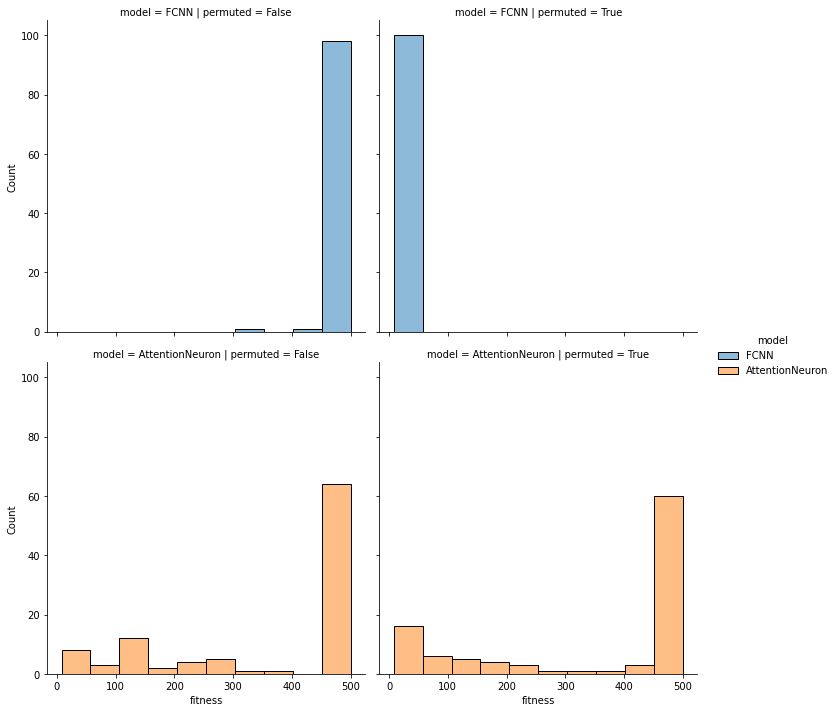

In [39]:
df = pd.DataFrame(results)
sns.displot(data=df, x="fitness", row="model", col="permuted", hue="model")